In [1]:
import pandas as pd
from geopandas import GeoSeries, GeoDataFrame

# Read data

In [2]:
spire_positions_file_path = "../../data/spire_positions_subset_02022024.csv"

In [3]:
spire_positions_df = pd.read_csv(
    spire_positions_file_path,
    parse_dates=[
        "timestamp",
        "last_position_time",
        "voyage_eta"
    ],
    infer_datetime_format=True,
    dtype={
        "IMO": str,
        "mmsi": str,
    }
)

In [4]:
spire_positions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8173 entries, 0 to 8172
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  8173 non-null   object        
 1   timestamp           8173 non-null   datetime64[ns]
 2   ship_name           8173 non-null   object        
 3   IMO                 8173 non-null   object        
 4   vessel_id           8173 non-null   int64         
 5   mmsi                8173 non-null   object        
 6   last_position_time  8173 non-null   datetime64[ns]
 7   position            8173 non-null   object        
 8   speed               8173 non-null   float64       
 9   navigation_status   8173 non-null   object        
 10  vessel_length       8173 non-null   int64         
 11  vessel_width        8173 non-null   int64         
 12  voyage_destination  7672 non-null   object        
 13  voyage_draught      7430 non-null   float64     

In [5]:
spire_positions_df.head()

,id,timestamp,ship_name,IMO,vessel_id,mmsi,last_position_time,position,speed,navigation_status,vessel_length,vessel_width,voyage_destination,voyage_draught,voyage_eta,accuracy,position_sensors,course,heading,rot
0,5997bb31-ec64-4c7b-8b41-1856ac09da85,2024-01-26 00:15:00,ANNELIES ILENA,9204556,1431,261084090,2024-01-23 11:11:01,0101000020E6100000184339D1AE521240ACD75F3C243B...,0.0,MOORED,24,145,IJMUIDEN,8.5,2023-12-12 02:00:00,LOW,TERRESTRIAL,324.4,212.0,0.0
1,0aaec083-c449-4698-9cdf-2b793b368ce8,2024-01-26 00:15:00,UK153 LUB SENIOR,9599731,1280,246749000,2024-01-25 18:49:58,0101000020E61000007F6993BBB664F93FA80018CFA05D...,0.0,ENGAGED_IN_FISHING,7,26,FISHING GROUND,5.0,2023-08-21 00:00:00,LOW,TERRESTRIAL,104.1,121.0,0.0
2,76ca3c41-7d70-4e7d-8e39-d0f21cfc6ff2,2024-01-26 00:15:00,SL-9 JOHANNA,7928835,1194,244938000,2024-01-25 17:13:17,0101000020E610000002DA1497FC62F93F225FD769035D...,0.0,NOT_DEFINED_DEFAULT,8,35,FISHING GROUNDS,4.0,NaT,NaN,SATELLITE,299.0,NaN,NaN
3,e589c17d-fa97-4af4-8463-c0e299ec6489,2024-01-26 00:15:00,PARADANTA PRIMERO,8516043,621,224378000,2024-01-26 00:10:35,0101000020E6100000E82531CE80194CC01B12F758FA72...,0.0,MOORED,10,58,CALADEROS,6.6,NaT,LOW,TERRESTRIAL,61.0,256.0,0.0
4,944570d7-7279-4a2c-a00b-b151d413ed47,2024-01-26 00:15:00,HENDRIKA JACOBA,9877389,920,232031183,2024-01-25 05:08:33,0101000020E6100000A4880CAB78830040F47C9B3818D1...,0.4,ENGAGED_IN_FISHING,9,25,FISHING,4.6,2024-01-24 12:15:00,HIGH,TERRESTRIAL,53.0,150.0,0.0


# Analysis

## Count records by "mmsi"

In [6]:
spire_positions_df.groupby("mmsi")["id"].count()

mmsi
224378000     743
226347000     743
227302000     743
228066900     743
228215800     743
232031183     743
244938000     743
246749000    1486
261084090     743
263581000     743
Name: id, dtype: int64

## Count "ship_name" by "mmsi"

In [7]:
ship_name_by_mmsi_df = pd.DataFrame()
ship_name_by_mmsi_df["ship_name_list"] = spire_positions_df.groupby("mmsi")["ship_name"].unique()
ship_name_by_mmsi_df["n_ship_name"] = ship_name_by_mmsi_df["ship_name_list"].str.len()

In [8]:
ship_name_by_mmsi_df

,ship_name_list,n_ship_name
mmsi,,
224378000,[PARADANTA PRIMERO],1
226347000,[SCOMBRUS],1
227302000,[PRINS BERNHARD],1
228066900,[F/V GEVRED],1
228215800,[F/V VENT DU NORD II],1
232031183,[HENDRIKA JACOBA],1
244938000,[SL-9 JOHANNA],1
246749000,"[UK153 LUB SENIOR, UK153 LUB""B!VYOR""]",2
261084090,[ANNELIES ILENA],1


In [9]:
ship_name_by_mmsi_df[ship_name_by_mmsi_df["n_ship_name"] < 1]

,ship_name_list,n_ship_name
mmsi,,


In [10]:
ship_name_by_mmsi_df[ship_name_by_mmsi_df["n_ship_name"] > 1]

,ship_name_list,n_ship_name
mmsi,,
246749000,"[UK153 LUB SENIOR, UK153 LUB""B!VYOR""]",2


## "speed" (reported by AIS)

<Axes: ylabel='Frequency'>

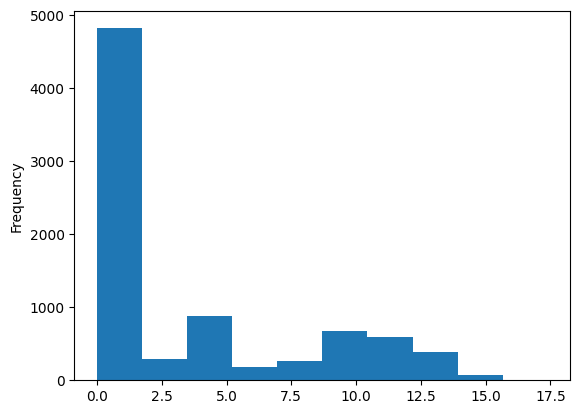

In [11]:
spire_positions_df["speed"].plot.hist()

## Compute speed from positions and timestamps

### Use timestamps to compute the time delta between two consecutive positions of a given "mmsi"

In [12]:
spire_positions_df["time_delta_seconds"] = spire_positions_df.sort_values(["mmsi", "last_position_time"]).groupby("mmsi")["last_position_time"].diff().dt.total_seconds()

In [13]:
spire_positions_df[["mmsi", "time_delta_seconds"]].head()

,mmsi,time_delta_seconds
0,261084090,NaN
1,246749000,777874.0
2,244938000,NaN
3,224378000,NaN
4,232031183,NaN


### Compute distance by parsing points from "position"

TODO: Check that the distances are computed correctly

In [14]:
def compute_distance(group_series):
    shifted_points_series = group_series.shift()
    return shifted_points_series.distance(group_series)

In [15]:
spire_positions_df["position_geometry"] = GeoSeries.from_wkb(spire_positions_df["position"], crs='EPSG:4326').to_crs('EPSG:5234')

In [16]:
spire_positions_df = GeoDataFrame(spire_positions_df)

In [17]:
spire_positions_df["distance"] = spire_positions_df.sort_values(["mmsi", "last_position_time"])["position_geometry"].distance(spire_positions_df.sort_values(["mmsi", "last_position_time"])["position_geometry"].shift())

In [18]:
spire_positions_df.sort_values(["mmsi", "last_position_time"])[["mmsi", "time_delta_seconds", "distance"]].head(10)

,mmsi,time_delta_seconds,distance
3,224378000,NaN,NaN
14,224378000,905.0,3.352541
25,224378000,895.0,2.637034
36,224378000,902.0,4.686830
47,224378000,889.0,5.373628
58,224378000,915.0,5.735154
69,224378000,916.0,1.157203
80,224378000,860.0,2.584555
91,224378000,910.0,1.880431
102,224378000,908.0,5.459524


### TODO: Compute speed from distance and time delta